In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib

In [2]:
input_parameters = [
    'Mass', 
    'Radius',
    'H2O_mass_frac', 
]

output_parameters = [
    'H2O_radial_frac',
    'Mantle_radial_frac',
    'Core_radial_frac',
    'Core_mass_frac',
    'P_CMB', 
    'T_CMB',
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "RockyExop_MDN_20210412.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("MDN_INPUT_scaler20210412.save")
output_scaler = joblib.load("MDN_OUTPUT_scaler20210412.save")


## Predict Earth (for example)

In [3]:
# EARTH
# input mass and radius for predicting must be earth units
input_array_earth = np.array(
    [
        [1], # mass
        [1], # radius
        [0.0005], # water mass fraction
    ]
)
scaled_input = input_scaler.transform(input_array_earth.T)

In [4]:
pred = model.predict(scaled_input)
# pred contains parameters for distributions, not actual points on the graph.
print(pred)
print(pred.shape)

[[ 3.03289294e-03  4.25442994e-01  6.33758724e-01  3.85111332e-01
   8.76477808e-02  2.56205469e-01  4.70718741e-03  4.19880003e-01
   6.38005972e-01  4.00346518e-01  8.59680176e-02  2.51798242e-01
   1.24986768e-02  3.21314454e-01  7.47127056e-01  5.77542245e-01
   6.96435720e-02  2.23784477e-01  8.11555982e-03  4.38728154e-01
   6.17383659e-01  3.65206301e-01  8.61660764e-02  2.52602160e-01
   1.05639696e-02  3.81464452e-01  6.78528011e-01  4.63191420e-01
   8.18987936e-02  2.46104375e-01  7.25030899e-03  4.53395605e-01
   6.00430489e-01  3.39207709e-01  8.59087706e-02  2.51002967e-01
   9.46387649e-03  3.75099123e-01  6.80678368e-01  4.69653726e-01
   8.20860863e-02  2.47579694e-01  6.38002157e-03  3.98747355e-01
   6.62988901e-01  4.36875463e-01  8.07971656e-02  2.43895382e-01
   3.01328301e-03  3.91636997e-01  6.67933762e-01  4.49547648e-01
   8.38221163e-02  2.45810136e-01  7.49057531e-03  4.03100491e-01
   6.56363845e-01  4.24108416e-01  7.85701722e-02  2.42915958e-01
   6.12547

In [5]:
# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

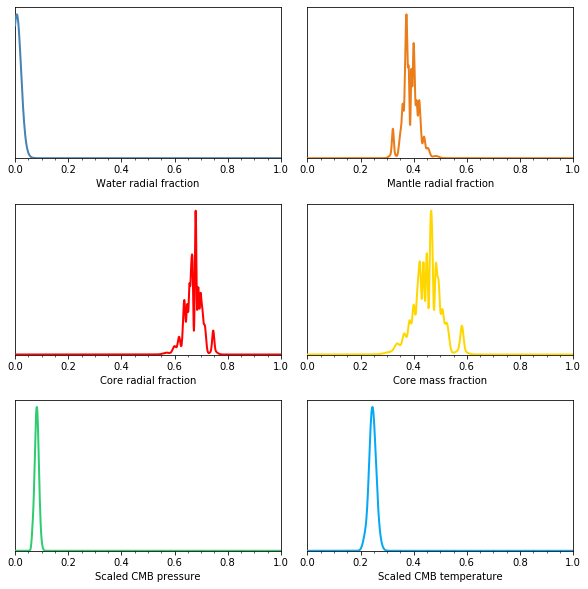

In [6]:
colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
predict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "Scaled CMB pressure", 
    "Scaled CMB temperature"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), predict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(bottom=0)
    ax.set_yticks([])
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xlabel(predict_label[i])
# plt.savefig('512EARTH-water.eps')